## Introduction
This notebook explores DistilBERT that is fine tuned to do sentiment analysis on sst2 dataset. The baseline as comparison is DistillBERT without fine tuning and a machine learning SVM model. Evaluation uses accuracy, precision, recall and f1 score

Muhammad Adnan Rizqullah (2403851)

**Requirements:** This notebook is tested to run with Python 3.11.11

In [1]:
import sys
import warnings

required_version = "3.11.11"
current_version = sys.version.split()[0]

if current_version != required_version:
    warnings.warn(f"⚠️ This notebook is tested to run with Python {current_version}. Proceeding may cause compatibility issues.")
    
print(f"Python version: {current_version}")

Python version: 3.11.11


In [ ]:
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab, installing missing packages...")
    %pip install datasets
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab, installing from requirements file...")
    %pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import random
import torch
import os
from transformers import set_seed
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from datasets import concatenate_datasets
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

/opt/homebrew/anaconda3/envs/cs681-final-sa-test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def get_device_info():
    """Detect and return the best available device with its capabilities"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        device_name = torch.cuda.get_device_name(0)
        device_type = "CUDA"
        supports_fp16 = True  # CUDA generally supports fp16
        max_batch_size = 32  # Typical for T4 GPUs
        print(f"Using CUDA GPU: {device_name}")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
        device_name = "Apple Silicon"
        device_type = "MPS"
        supports_fp16 = False  # MPS has limited fp16 support
        max_batch_size = 16   # Conservative for M1 chips
        print(f"Using Apple Silicon GPU (MPS)")
    else:
        device = torch.device("cpu")
        device_name = "CPU"
        device_type = "CPU"
        supports_fp16 = False
        max_batch_size = 8  # Conservative for CPU
        print("Using CPU (no GPU available)")
    
    return {
        "device": device,
        "name": device_name,
        "type": device_type,
        "supports_fp16": supports_fp16,
        "max_batch_size": max_batch_size
    }

# Get device information
device_info = get_device_info()

Using Apple Silicon GPU (MPS)


In [ ]:
# Get optimal device-specific settings
device_info = get_device_info()

config = {
    "seed": 42,
    "model_name": "distilbert-base-uncased",
    "model_num_labels": 2,
    "dataset_name": "stanfordnlp/sst2",
    "train_split_ratio": 0.7,
    "validation_split_ratio": 0.15,
    "dev_split_ratio": 0.1,
    "test_split_ratio": 0.05,
    # Dynamically set data sizes based on available hardware
    "train_subset_size": 1750 if device_info["type"] in ["CUDA"] else 200,
    "validation_subset_size": 325 if device_info["type"] in ["CUDA"] else 50,
    "dev_subset_size": 250 if device_info["type"] in ["CUDA"] else 50,
    "test_subset_size": 125 if device_info["type"] in ["CUDA"] else 50,
    "num_proc": 4,
    "tokenizer_padding": "max_length",
    "tokenizer_truncation": True,
    "tokenizer_max_length": 512,
    "output_dir": "./results",
    "learning_rate": 2e-5,
    "train_batch_size": device_info["max_batch_size"],
    "eval_batch_size": device_info["max_batch_size"] * 2,
    "num_epochs": 5,
    "weight_decay": 0.01,
    "evaluation_strategy": "epoch",
    # Device-specific settings
    "device": device_info["device"],
    "device_type": device_info["type"],
    "fp16": device_info["supports_fp16"],
    "gradient_accumulation_steps": 2
}

print(f"Configuration loaded successfully for {config['device_type']}")

Using Apple Silicon GPU (MPS)
Configuration loaded successfully for MPS


In [6]:
SEED = config["seed"]

# Set seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device-specific seeding
if config["device_type"] == "CUDA":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("CUDA seed set")

set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

print(f"All random seeds have been set to {SEED} for reproducibility")

All random seeds have been set to 42 for reproducibility


## Dataset preparation
This section analyzes and prepares the dataset for training:
1. Explored the number of rows and labels distribution
2. Use down-sampling to balance the dataset to have equal number of labels for each label
3. Explored how the text content looks like in the dataset
4. Split the dataset into training, validation, dev, and test set

In [7]:
dataset = load_dataset(config["dataset_name"])

In [8]:
print("Dataset info:")
print(f"Dataset type: {type(dataset)}")
print(f"Dataset splits: {dataset.keys()}")
print("\nNumber of examples per split:")
for split in dataset.keys():
  print(f"  {split}: {len(dataset[split])}")

print("\nFeatures in the dataset:")
for feature in dataset['train'].features:
  print(f"  {feature}: {dataset['train'].features[feature]}")

print("\nLabel distribution:")
for split in dataset.keys():
  label_counts = {}
  for label in dataset[split]['label']:
    if label not in label_counts:
      label_counts[label] = 0
    label_counts[label] += 1
  print(f"  {split}: {label_counts}")

Dataset info:
Dataset type: <class 'datasets.dataset_dict.DatasetDict'>
Dataset splits: dict_keys(['train', 'validation', 'test'])

Number of examples per split:
  train: 67349
  validation: 872
  test: 1821

Features in the dataset:
  idx: Value(dtype='int32', id=None)
  sentence: Value(dtype='string', id=None)
  label: ClassLabel(names=['negative', 'positive'], id=None)

Label distribution:
  train: {0: 29780, 1: 37569}
  validation: {1: 444, 0: 428}
  test: {-1: 1821}


In [9]:
train_positive = dataset['train'].filter(lambda example: example['label'] == 1)
train_negative = dataset['train'].filter(lambda example: example['label'] == 0)

print(f"Original training positive samples: {len(train_positive)}")
print(f"Original training negative samples: {len(train_negative)}")

positive_indices = np.random.choice(len(train_positive), len(train_negative), replace=False)
downsampled_train_positive = train_positive.select(positive_indices)

balanced_train = concatenate_datasets([downsampled_train_positive, train_negative])
balanced_train = balanced_train.shuffle(seed=config["seed"])

print(f"Total samples in balanced training set: {len(balanced_train)}")

val_positive = dataset['validation'].filter(lambda example: example['label'] == 1)
val_negative = dataset['validation'].filter(lambda example: example['label'] == 0)

print(f"Validation positive samples: {len(val_positive)}")
print(f"Validation negative samples: {len(val_negative)}")

if len(val_positive) > len(val_negative):
    val_positive_indices = np.random.choice(len(val_positive), len(val_negative), replace=False)
    balanced_val_positive = val_positive.select(val_positive_indices)
    balanced_validation = concatenate_datasets([balanced_val_positive, val_negative])
else:
    val_negative_indices = np.random.choice(len(val_negative), len(val_positive), replace=False)
    balanced_val_negative = val_negative.select(val_negative_indices)
    balanced_validation = concatenate_datasets([val_positive, balanced_val_negative])

balanced_validation = balanced_validation.shuffle(seed=config["seed"])
print(f"Total samples in balanced validation set: {len(balanced_validation)}")

combined_dataset = concatenate_datasets([balanced_train, balanced_validation])
combined_dataset = combined_dataset.shuffle(seed=config["seed"])

print(f"\nTotal samples in combined dataset: {len(combined_dataset)}")

combined_balance = {}
for label in combined_dataset['label']:
    if label not in combined_balance:
        combined_balance[label] = 0
    combined_balance[label] += 1
print(f"Combined dataset label distribution: {combined_balance}")

Original training positive samples: 37569
Original training negative samples: 29780
Total samples in balanced training set: 59560
Validation positive samples: 444
Validation negative samples: 428
Total samples in balanced validation set: 856

Total samples in combined dataset: 60416
Combined dataset label distribution: {1: 30208, 0: 30208}


In [10]:
print("\nText length statistics (characters):")
lengths = [len(text) for text in combined_dataset['sentence']]
print(f"  Min: {min(lengths)}")
print(f"  Max: {max(lengths)}")
print(f"  Mean: {np.mean(lengths):.2f}")
print(f"  Median: {np.median(lengths):.2f}")

print("\nWord count statistics:")
word_counts = [len(text.split()) for text in combined_dataset['sentence']]
print(f"  Min: {min(word_counts)}")
print(f"  Max: {max(word_counts)}")
print(f"  Mean: {np.mean(word_counts):.2f}")
print(f"  Median: {np.median(word_counts):.2f}")

print("\nSample examples from combined dataset:")
for i in range(3):  
    print(f"  Example {i+1}:")
    print(f"    Text: {combined_dataset['sentence'][i]}")
    print(f"    Label: {combined_dataset['label'][i]} ({['Negative', 'Positive'][combined_dataset['label'][i]]})") 
    print()


Text length statistics (characters):
  Min: 2
  Max: 268
  Mean: 54.43
  Median: 40.00

Word count statistics:
  Min: 1
  Max: 52
  Mean: 9.60
  Median: 7.00

Sample examples from combined dataset:
  Example 1:
    Text: the emotion is impressively true for being so hot-blooded 
    Label: 1 (Positive)

  Example 2:
    Text: botches 
    Label: 0 (Negative)

  Example 3:
    Text: tricky and satisfying as any of david 
    Label: 1 (Positive)



In [11]:
dataset_size = len(combined_dataset)

train_size = int(dataset_size * config["train_split_ratio"])
val_size = int(dataset_size * config["validation_split_ratio"])
dev_size = int(dataset_size * config["dev_split_ratio"])
test_size = dataset_size - train_size - val_size - dev_size

print(f"Split sizes: Train={train_size}, Val={val_size}, Dev={dev_size}, Test={test_size}")

train_dataset = combined_dataset.select(range(train_size))
val_dataset = combined_dataset.select(range(train_size, train_size + val_size))
dev_dataset = combined_dataset.select(range(train_size + val_size, train_size + val_size + dev_size))
test_dataset = combined_dataset.select(range(train_size + val_size + dev_size, dataset_size))

print(f"\nFinal dataset sizes:")
print(f"Train: {len(train_dataset)} samples ({len(train_dataset)/dataset_size*100:.1f}%)")
print(f"Validation: {len(val_dataset)} samples ({len(val_dataset)/dataset_size*100:.1f}%)")
print(f"Dev: {len(dev_dataset)} samples ({len(dev_dataset)/dataset_size*100:.1f}%)")
print(f"Test: {len(test_dataset)} samples ({len(test_dataset)/dataset_size*100:.1f}%)")

for split_name, split_dataset in [("Train", train_dataset), ("Validation", val_dataset), 
                                 ("Dev", dev_dataset), ("Test", test_dataset)]:
    label_counts = {}
    for label in split_dataset['label']:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1
    print(f"{split_name} label distribution: {label_counts}")

Split sizes: Train=42291, Val=9062, Dev=6041, Test=3022

Final dataset sizes:
Train: 42291 samples (70.0%)
Validation: 9062 samples (15.0%)
Dev: 6041 samples (10.0%)
Test: 3022 samples (5.0%)
Train label distribution: {1: 21226, 0: 21065}
Validation label distribution: {1: 4508, 0: 4554}
Dev label distribution: {0: 3107, 1: 2934}
Test label distribution: {1: 1540, 0: 1482}


## Model creation
This section prepares the model and does the training:
1. Tokenize dataset
2. Determine metrics for training loss
3. Determine the training hyper-parameters
4. Train the models

In [12]:
tokenizer = DistilBertTokenizer.from_pretrained(config["model_name"])
model = DistilBertForSequenceClassification.from_pretrained(config["model_name"], num_labels=config["model_num_labels"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
base_model = DistilBertForSequenceClassification.from_pretrained(config["model_name"], num_labels=config["model_num_labels"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Move models to the appropriate device
model = model.to(config["device"])
base_model = base_model.to(config["device"])
print(f"Models loaded and moved to {config['device_type']}")

Models loaded and moved to MPS


In [15]:
def tokenize_function(examples):
    return tokenizer(examples['sentence'], 
                    padding=config["tokenizer_padding"], 
                    truncation=config["tokenizer_truncation"],
                    max_length=config["tokenizer_max_length"])

tokenized_train = train_dataset.map(tokenize_function, batched=True, num_proc=config["num_proc"])
tokenized_val = val_dataset.map(tokenize_function, batched=True, num_proc=config["num_proc"])
tokenized_dev = dev_dataset.map(tokenize_function, batched=True, num_proc=config["num_proc"])
tokenized_test = test_dataset.map(tokenize_function, batched=True, num_proc=config["num_proc"])

In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
training_args = TrainingArguments(
    output_dir=config["output_dir"],
    learning_rate=config["learning_rate"],
    per_device_train_batch_size=config["train_batch_size"],
    per_device_eval_batch_size=config["eval_batch_size"],
    num_train_epochs=config["num_epochs"],
    weight_decay=config["weight_decay"],
    eval_strategy=config["evaluation_strategy"],
    fp16=config["fp16"],  # Uses FP16 only for CUDA devices
    gradient_accumulation_steps=config["gradient_accumulation_steps"],
    # Handle special case for MPS
    use_mps_device=(config["device_type"] == "MPS"),
    seed=config["seed"],
    data_seed=config["seed"],
    report_to="none"
)

/opt/homebrew/anaconda3/envs/cs681-final-sa-test/lib/python3.11/site-packages/transformers/training_args.py:2243: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train.select(range(config["train_subset_size"])),
    eval_dataset=tokenized_val.select(range(config["validation_subset_size"])),
    compute_metrics=compute_metrics
)

In [19]:
trainer.train()

/opt/homebrew/anaconda3/envs/cs681-final-sa-test/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.705902,0.460000,0.460000,1.000000,0.630137


/opt/homebrew/anaconda3/envs/cs681-final-sa-test/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/envs/cs681-final-sa-test/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=12, training_loss=0.6631497542063395, metrics={'train_runtime': 102.1001, 'train_samples_per_second': 3.918, 'train_steps_per_second': 0.118, 'total_flos': 47688263516160.0, 'train_loss': 0.6631497542063395, 'epoch': 1.7692307692307692})

In [20]:
print("Creating SVM baseline model...")
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('svm', LinearSVC(random_state=config["seed"], dual=False))
])

X_train_subset = [train_dataset['sentence'][i] for i in range(config["train_subset_size"])]
y_train_subset = [train_dataset['label'][i] for i in range(config["train_subset_size"])]

print(f"Training SVM on {len(X_train_subset)} examples...")
svm_pipeline.fit(X_train_subset, y_train_subset)

Creating SVM baseline model...
Training SVM on 200 examples...


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('svm', LinearSVC(dual=False, random_state=42))])

## Model Evaluation
This section evaluates the each model and compares their performance

In [21]:
val_results = trainer.evaluate()
print("\nValidation Results:")
for key, value in val_results.items():
  if isinstance(value, float):
    print(f"  {key}: {value:.4f}")
  else:
    print(f"  {key}: {value}")

/opt/homebrew/anaconda3/envs/cs681-final-sa-test/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Validation Results:
  eval_loss: 0.7059
  eval_accuracy: 0.4600
  eval_precision: 0.4600
  eval_recall: 1.0000
  eval_f1: 0.6301
  eval_runtime: 5.2836
  eval_samples_per_second: 9.4630
  eval_steps_per_second: 0.3790
  epoch: 1.7692


In [22]:
dev_trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_dev.select(range(config["dev_subset_size"])),
    compute_metrics=compute_metrics,
)

dev_results = dev_trainer.evaluate()
print("\nDev set evaluation results:")
for key, value in dev_results.items():
  if isinstance(value, float):
    print(f"  {key}: {value:.4f}")
  else:
    print(f"  {key}: {value}")

/opt/homebrew/anaconda3/envs/cs681-final-sa-test/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Dev set evaluation results:
  eval_loss: 0.7013
  eval_model_preparation_time: 0.0007
  eval_accuracy: 0.4200
  eval_precision: 0.4200
  eval_recall: 1.0000
  eval_f1: 0.5915
  eval_runtime: 3.8348
  eval_samples_per_second: 13.0380
  eval_steps_per_second: 0.5220


In [23]:
test_trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    eval_dataset=tokenized_test.select(range(config["test_subset_size"]))
)

test_results = test_trainer.evaluate()
print("\nTest set evaluation results:")
for key, value in test_results.items():
  if isinstance(value, float):
    print(f"  {key}: {value:.4f}")
  else:
    print(f"  {key}: {value}")

/opt/homebrew/anaconda3/envs/cs681-final-sa-test/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Test set evaluation results:
  eval_loss: 0.6720
  eval_model_preparation_time: 0.0024
  eval_accuracy: 0.6200
  eval_precision: 0.6200
  eval_recall: 1.0000
  eval_f1: 0.7654
  eval_runtime: 3.7050
  eval_samples_per_second: 13.4950
  eval_steps_per_second: 0.5400


This part is the test set performance of DistillBERT without fine tuning

In [24]:
base_test_trainer = Trainer(
    model=base_model,
    args=training_args,
    compute_metrics=compute_metrics,
    eval_dataset=tokenized_test.select(range(config["test_subset_size"]))
)

base_test_results = base_test_trainer.evaluate()
print("\nBase (non-fine-tuned) model test results:")
for key, value in base_test_results.items():
  if isinstance(value, float):
    print(f"  {key}: {value:.4f}")
  else:
    print(f"  {key}: {value}")

/opt/homebrew/anaconda3/envs/cs681-final-sa-test/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Base (non-fine-tuned) model test results:
  eval_loss: 0.6950
  eval_model_preparation_time: 0.0025
  eval_accuracy: 0.4200
  eval_precision: 0.6667
  eval_recall: 0.1290
  eval_f1: 0.2162
  eval_runtime: 7.9035
  eval_samples_per_second: 6.3260
  eval_steps_per_second: 0.2530


This part is the test set performance of SVM

In [25]:
X_test_subset = [test_dataset['sentence'][i] for i in range(config["test_subset_size"])]
y_test_subset = [test_dataset['label'][i] for i in range(config["test_subset_size"])]

svm_predictions = svm_pipeline.predict(X_test_subset)

svm_accuracy = accuracy_score(y_test_subset, svm_predictions)
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(
    y_test_subset, svm_predictions, average='binary'
)

svm_test_results = {
    'eval_accuracy': svm_accuracy,
    'eval_precision': svm_precision,
    'eval_recall': svm_recall,
    'eval_f1': svm_f1,
    'accuracy': svm_accuracy,
    'precision': svm_precision, 
    'recall': svm_recall,
    'f1': svm_f1
}

print("\nSVM model test results:")
for key, value in svm_test_results.items():
  if key.startswith('eval_'):
    continue
  if isinstance(value, float):
    print(f"  {key}: {value:.4f}")
  else:
    print(f"  {key}: {value}")


SVM model test results:
  accuracy: 0.6000
  precision: 0.6571
  recall: 0.7419
  f1: 0.6970


In [26]:
print("\nPerformance comparison (Test Set):")
print(f"{'Metric':<30} {'Fine-tuned':<15} {'Base model':<15} {'SVM':<15}")
print("-" * 75)
for key in test_results:
    if isinstance(test_results[key], float):
        svm_value = svm_test_results.get(key, 0)
        improvement_ft = test_results[key] - base_test_results[key]
        improvement_svm = svm_value - base_test_results[key]
        print(f"{key:<30} {test_results[key]:.4f}{'':<8} {base_test_results[key]:.4f}{'':<8} {svm_value:.4f}")


Performance comparison (Test Set):
Metric                         Fine-tuned      Base model      SVM            
---------------------------------------------------------------------------
eval_loss                      0.6720         0.6950         0.0000
eval_model_preparation_time    0.0024         0.0025         0.0000
eval_accuracy                  0.6200         0.4200         0.6000
eval_precision                 0.6200         0.6667         0.6571
eval_recall                    1.0000         0.1290         0.7419
eval_f1                        0.7654         0.2162         0.6970
eval_runtime                   3.7050         7.9035         0.0000
eval_samples_per_second        13.4950         6.3260         0.0000
eval_steps_per_second          0.5400         0.2530         0.0000


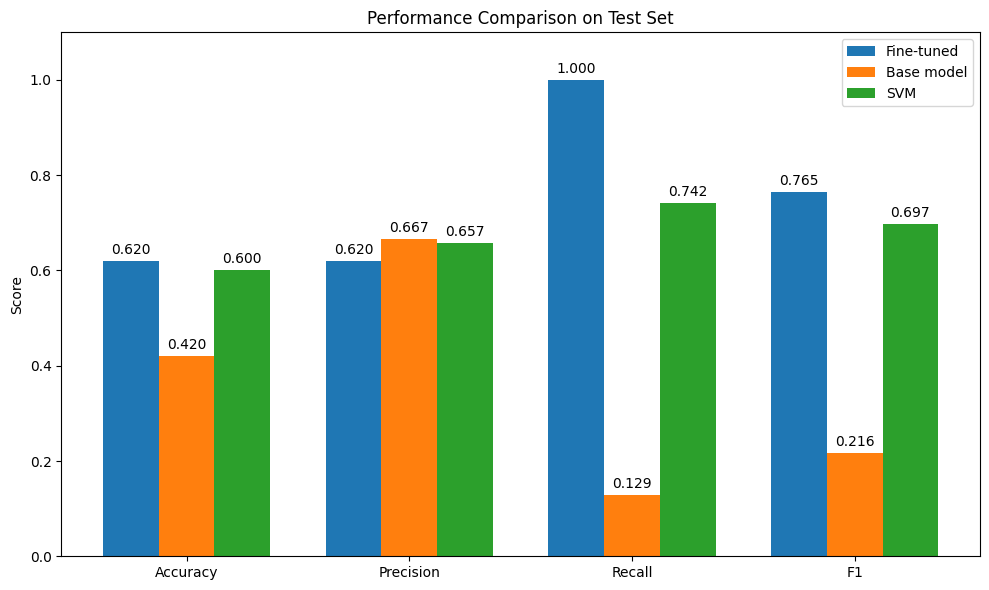

In [27]:
metrics = ['accuracy', 'precision', 'recall', 'f1']
fine_tuned_values = [test_results[f'eval_{m}'] for m in metrics]
base_values = [base_test_results[f'eval_{m}'] for m in metrics]
svm_values = [svm_test_results[f'eval_{m}'] for m in metrics]

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, fine_tuned_values, width, label='Fine-tuned')
rects2 = ax.bar(x, base_values, width, label='Base model')
rects3 = ax.bar(x + width, svm_values, width, label='SVM')

ax.set_ylabel('Score')
ax.set_title('Performance Comparison on Test Set')
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics])
ax.legend()
ax.set_ylim(0, 1.1)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.tight_layout()
plt.show()

In [28]:
def predict_sentiment_with_model(text, model_to_use):
    device = config["device"]
    
    try:
        # Tokenize input text
        inputs = tokenizer(text, return_tensors="pt", 
                           padding=config["tokenizer_padding"], 
                           truncation=config["tokenizer_truncation"], 
                           max_length=config["tokenizer_max_length"])
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Run prediction
        model_on_device = model_to_use.to(device)
        
        with torch.no_grad():
            outputs = model_on_device(**inputs)
        
        predictions = torch.argmax(outputs.logits, dim=-1).item()
        return "Positive" if predictions == 1 else "Negative"
            
    except Exception as e:
        print(f"Error with {device.type}: {e}. Falling back to CPU.")
        device = torch.device("cpu")
        inputs = tokenizer(text, return_tensors="pt", 
                       padding=config["tokenizer_padding"], 
                       truncation=config["tokenizer_truncation"], 
                       max_length=config["tokenizer_max_length"])
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        model_on_device = model_to_use.to(device)
        with torch.no_grad():
            outputs = model_on_device(**inputs)
        
        predictions = torch.argmax(outputs.logits, dim=-1).item()
        return "Positive" if predictions == 1 else "Negative"

In [29]:
def predict_sentiment(text):
    return predict_sentiment_with_model(text, model)

In [30]:
def predict_sentiment_base(text):
    return predict_sentiment_with_model(text, base_model)

In [31]:
def predict_sentiment_svm(text):
    prediction = svm_pipeline.predict([text])[0]
    return "Positive" if prediction == 1 else "Negative"

In [32]:
test_examples = [
    ("Bad", "Negative"),
    ("Good", "Positive"),
    ("I hate this", "Negative"),
    ("I love this", "Positive"),
    ("This movie was OK", "Positive"),
    ("This movie was fantastic", "Positive"),
    ("This movie was terrible", "Negative"),
    ("This is not bad", "Positive"),
    ("Good movie but bad acting", "Positive"),
    ("Despite the poor beginning, the ending was great", "Positive"),
    ("The plot was intricate and the characters were well developed", "Positive"),
    ("A masterpiece of modern cinema with stunning visuals", "Positive"),    
    ("The director failed to engage the audience", "Negative"),
    ("Not the best film I've seen, but still enjoyable", "Positive"),
    ("I wouldn't recommend this to anyone", "Negative"),
    ("It wasn't as bad as the critics suggested", "Positive"),
    ("Absolutely brilliant performances by the entire cast", "Positive"),
    ("A complete waste of time and money", "Negative"),
    ("The special effects couldn't save the weak storyline", "Negative"),
    ("Despite its flaws, the film manages to be entertaining", "Positive"),
    ("It's so bad it's actually good", "Positive"),
    ("The film offers nothing new to the genre", "Negative"),
    ("While not perfect, it exceeded my expectations", "Positive"),
    ("The soundtrack was the only redeeming quality", "Negative")
]

print("\nComparing predictions across all models:")
print(f"{'Text':<60} {'Ground Truth':<15} {'Fine-tuned':<15} {'Base model':<15} {'SVM':<15}")
print("-" * 120)

matches_ft_base = 0
matches_ft_svm = 0
matches_base_svm = 0
fine_tuned_correct = 0
base_correct = 0
svm_correct = 0

for example, ground_truth in test_examples:
    fine_tuned_pred = predict_sentiment(example)
    base_pred = predict_sentiment_base(example)
    svm_pred = predict_sentiment_svm(example)
    
    if fine_tuned_pred == base_pred:
        matches_ft_base += 1
    if fine_tuned_pred == svm_pred:
        matches_ft_svm += 1
    if base_pred == svm_pred:
        matches_base_svm += 1
    
    if ground_truth in ["Positive", "Negative"]:
        if fine_tuned_pred == ground_truth:
            fine_tuned_correct += 1
        if base_pred == ground_truth:
            base_correct += 1
        if svm_pred == ground_truth:
            svm_correct += 1
    
    display_text = example[:60] + "..." if len(example) > 60 else example
    print(f"{display_text:<60} {ground_truth:<15} {fine_tuned_pred:<15} {base_pred:<15} {svm_pred:<15}")

binary_examples = sum(1 for _, label in test_examples if label in ["Positive", "Negative"])
fine_tuned_acc = (fine_tuned_correct / binary_examples) * 100 if binary_examples > 0 else 0
base_acc = (base_correct / binary_examples) * 100 if binary_examples > 0 else 0
svm_acc = (svm_correct / binary_examples) * 100 if binary_examples > 0 else 0

ft_base_agreement = (matches_ft_base / len(test_examples)) * 100
ft_svm_agreement = (matches_ft_svm / len(test_examples)) * 100
base_svm_agreement = (matches_base_svm / len(test_examples)) * 100

models = [
    ("Fine-tuned", fine_tuned_acc),
    ("Base", base_acc),
    ("SVM", svm_acc)
]
best_model = max(models, key=lambda x: x[1])[0]

print(f"\nModel agreement:")
print(f"Fine-tuned/Base agreement: {matches_ft_base}/{len(test_examples)} ({ft_base_agreement:.1f}%)")
print(f"Fine-tuned/SVM agreement: {matches_ft_svm}/{len(test_examples)} ({ft_svm_agreement:.1f}%)")
print(f"Base/SVM agreement: {matches_base_svm}/{len(test_examples)} ({base_svm_agreement:.1f}%)")

print(f"\nModel accuracy on test examples:")
print(f"Fine-tuned model: {fine_tuned_correct}/{binary_examples} ({fine_tuned_acc:.1f}%)")
print(f"Base model: {base_correct}/{binary_examples} ({base_acc:.1f}%)")
print(f"SVM model: {svm_correct}/{binary_examples} ({svm_acc:.1f}%)")
print(f"Best performing model: {best_model}")


Comparing predictions across all models:
Text                                                         Ground Truth    Fine-tuned      Base model      SVM            
------------------------------------------------------------------------------------------------------------------------
Bad                                                          Negative        Positive        Positive        Negative       
Good                                                         Positive        Positive        Positive        Positive       
I hate this                                                  Negative        Positive        Positive        Positive       
I love this                                                  Positive        Positive        Negative        Positive       
This movie was OK                                            Positive        Positive        Negative        Positive       
This movie was fantastic                                     Positive        Positive  